# Кейс «Прогнозирование оттока клиентов»

#### Суть бизнес задачи:

Каждый год компания пролонгирует полисы Каско клиентов - физических лиц. Для оптимизации работы со списками на пролонгацию необходимо прогнозировать с какой вероятностью каждый из клиентов пролонгируется и какие факторы на это влияют. В зависимости от этого расставляются приоритеты операторам колл-центра, которые обрабатывают список (осуществляют обзвон клиентов), а также принимаются решения по дополнительной мотивации клиентов к пролонгации.

### Библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

## Загрузка данных 

In [44]:
# Проблема с кодировкой 'utf-8' и 'windows-1251' 
# поэтому файл 'Данные для задачи - Ренессанс.txt' сохранил в кодировке 'ANSI'

data = pd.read_csv('Данные для задачи - Ренессанс.txt', engine='python', sep=';', encoding='ansi', 
                   index_col=1, skipinitialspace=True)

data.head()

,DATA_TYPE,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_MAKE,...,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
POLICY_ID,,,,,,,,,,,,,,,,,,,,,
1,TRAIN,1,1,1,39,1,Москва,51,12,Land Rover,...,N,1,0,0,0.0,0,0,0.0,Тульская,-1.00
2,TRAIN,1,1,1,50,5,Москва,35,7,Opel,...,0,1,1,0,0.0,0,4,0.0,Москва,-0.05
3,TRAIN,1,1,1,52,6,Москва,41,6,Kia,...,1L,0,0,0,0.0,0,1,12518.0,Московская,-0.07
4,TRAIN,1,1,1,50,5,Москва,36,12,Citroen,...,0,1,1,0,0.0,0,6,15000.0,Москва,0.05
5,TRAIN,1,1,0,52,6,Санкт-Петербург,42,5,Renault,...,N,0,0,0,0.0,0,0,50000.0,Ленинградская,0.17


In [5]:
data.shape

(96605, 29)

## 1. Предобработка данных

**DATA_TYPE** - Тип выборки	('TRAIN' - обучающая выборка, 'TEST' - тестовая выборка)                                             
**POLICY_ID** - ID полиса	
**POLICY_BEGIN_MONTH** - Месяц начала действия полиса	
**POLICY_END_MONTH** - Месяц окончания действия полиса	
**POLICY_IS_RENEWED** - Факт пролонгации полиса. Прогнозируемый параметр	Для тестовой выборки параметр обнулён               
**POLICY_SALES_CHANNEL** - Канал продаж полиса	
**POLICY_SALES_CHANNEL_GROUP** - Группа каналов продаж (группировка для колонки - канал продаж полиса) 	
**POLICY_BRANCH** - Филиал продажи полиса	
**POLICY_MIN_AGE** - Минимальный возраст лиц допущенных к управлению по полису	
**POLICY_MIN_DRIVING_EXPERIENCE** - Минимальный стаж вождения лиц допущенных к управлению по полису	
**VEHICLE_MAKE** - Марка ТС	
**VEHICLE_MODEL** - Модель ТС	
**VEHICLE_ENGINE_POWER** - Мощность двигателя ТС (Мощность в лошадиных силах)                                                   
**VEHICLE_IN_CREDIT** - ТС куплено в кредит	
**VEHICLE_SUM_INSURED** - Страховая сумма по полису (оценочная стоимость ТС - лимит возмещения)	
**POLICY_INTERMEDIARY**	- Посредник по полису (Идентификатор посредника)                                                         
**INSURER_GENDER** - Пол страхователя ('M' - мужчина, 'F' - женщина)                                                             
**POLICY_CLM_N** - Кол-во убытков, всего по данному полису  
("Цифра - количество убытков. 
Для клиентов с одним убытком:
Окончение S - small, сумма убытка меньше 60% премии по полису
Окончение L - large, сумма убытка больше 60% премии по полису)                                                                   
**POLICY_CLM_GLT_N** - Кол-во убытков, где клиент виновен в ДТП по данному полису                                               
**POLICY_PRV_CLM_N** - Кол-во убытков, всего по предыдущему (если есть) полису (клиент пролонгируется второй и более раз)
**POLICY_PRV_CLM_GLT_N** - Кол-во убытков, где клиент виновен в ДТП по предыдущему полису (клиент пролонгируется второй и более раз)	
**CLIENT_HAS_DAGO** - У клиента также есть полис ДАГО (ДАГО - расширение для страхования ответственности)	
**CLIENT_HAS_OSAGO** - У клиента также есть полис ОСАГО	
**POLICY_COURT_SIGN** -	По полису был суд	
**CLAIM_AVG_ACC_ST_PRD** - Среднее время от страхового случая до заявления убытков по данному полису	
**POLICY_HAS_COMPLAINTS** - По полису были жалобы (в том числе при урегулировании убытков)	
**POLICY_YEARS_RENEWED_N** - Количество лет пролонгации полиса	
**POLICY_DEDUCT_VALUE** - Сумма франшизы по полису	
**CLIENT_REGISTRATION_REGION** - Регион регистрации страхователя (Регион, где клиент зарегистрирован по паспорту)               
**POLICY_PRICE_CHANGE** - Как поменялась премия при пролонгации 
(""цена предложенная при пролонгации""-""цена пролонгируемого полиса"")/""цена пролонгируемого полиса""", Изменения в %, если > 0, то значит, что цена выросла)


### Избыточность информации

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96605 entries, 1 to 96605
Data columns (total 29 columns):
DATA_TYPE                        96605 non-null object
POLICY_BEGIN_MONTH               96605 non-null int64
POLICY_END_MONTH                 96605 non-null int64
POLICY_IS_RENEWED                96605 non-null int64
POLICY_SALES_CHANNEL             96605 non-null int64
POLICY_SALES_CHANNEL_GROUP       96605 non-null int64
POLICY_BRANCH                    96605 non-null object
POLICY_MIN_AGE                   96605 non-null int64
POLICY_MIN_DRIVING_EXPERIENCE    96605 non-null int64
VEHICLE_MAKE                     96605 non-null object
VEHICLE_MODEL                    96605 non-null object
VEHICLE_ENGINE_POWER             96605 non-null float64
VEHICLE_IN_CREDIT                96605 non-null int64
VEHICLE_SUM_INSURED              96605 non-null float64
POLICY_INTERMEDIARY              96605 non-null object
INSURER_GENDER                   96605 non-null object
POLICY_CLM_N     

In [4]:
data.describe()

,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_ENGINE_POWER,VEHICLE_IN_CREDIT,VEHICLE_SUM_INSURED,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_DEDUCT_VALUE,POLICY_PRICE_CHANGE
count,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000,9.660500e+04,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000
mean,6.891393,6.870400,0.500761,47.345251,5.123265,42.580767,34.910357,154.195851,0.321950,9.806700e+05,0.277480,0.550303,0.001014,3.877110,0.007660,5974.134461,-0.033025
std,3.400597,3.403665,0.500002,14.034159,1.585213,10.694670,199.928966,54.117543,0.467226,6.900919e+05,0.447758,0.497466,0.031834,17.635091,0.087186,10418.697183,0.857995
min,1.000000,1.000000,0.000000,1.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,4.000000,4.000000,0.000000,50.000000,5.000000,34.000000,8.000000,123.000000,0.000000,5.584960e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.170000
50%,7.000000,7.000000,1.000000,52.000000,6.000000,41.000000,14.000000,146.000000,0.000000,8.090000e+05,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,10.000000,1.000000,53.000000,6.000000,50.000000,19.000000,171.000000,1.000000,1.163900e+06,1.000000,1.000000,0.000000,0.000000,0.000000,10000.000000,0.050000
max,12.000000,12.000000,1.000000,63.000000,8.000000,86.000000,2015.000000,2000.000000,1.000000,9.449000e+06,1.000000,1.000000,1.000000,737.000000,1.000000,120873.000000,60.020000


Признаков относительно не так много, поэтому к методам понижений размерности прибегать не будем. Попробуем разобраться частично с каждым признаком.
Пропущенных значений нет, поэтому сразу построим матрицу корреляций, для того, чтобы понимать, какие признаки линейно зависимы между собой c первого же взгляда. Будем считать, что один из пары таких признаков - избыточная информация, которая не играет ключевую роль в наборе данных.

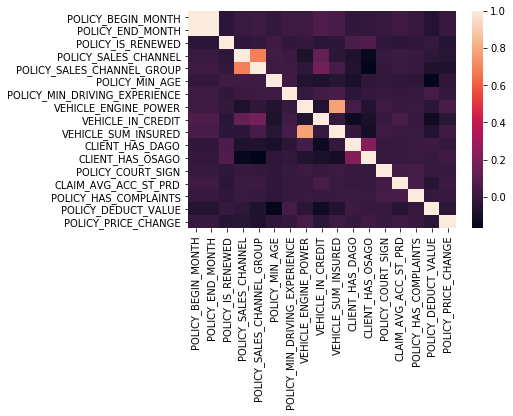

In [6]:
sns.heatmap(data.corr())

Видно, что такие признаки, как:                                                                                                 
**POLICY_BEGIN_MONTH** и **POLICY_END_MONTH**,                                                                                       
**POLICY_SALES_CHANNEL_GROUP** и **POLICY_SALES_CHANNEL**,                                                                           
**VEHICLE_SUM_INSURED** и **VEHICLE_ENGINE_POWER**                                                                               
показываю высокую линейную зависимость между собой.

In [27]:
data[['POLICY_BEGIN_MONTH', 'POLICY_END_MONTH', 'POLICY_SALES_CHANNEL_GROUP', 
      'POLICY_SALES_CHANNEL', 'VEHICLE_SUM_INSURED', 'VEHICLE_ENGINE_POWER']].corr()

,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_SALES_CHANNEL_GROUP,POLICY_SALES_CHANNEL,VEHICLE_SUM_INSURED,VEHICLE_ENGINE_POWER
POLICY_BEGIN_MONTH,1.000000,0.997728,0.017250,0.005576,0.051253,0.019254
POLICY_END_MONTH,0.997728,1.000000,0.016962,0.005666,0.052062,0.019657
POLICY_SALES_CHANNEL_GROUP,0.017250,0.016962,1.000000,0.688423,0.044398,-0.021546
POLICY_SALES_CHANNEL,0.005576,0.005666,0.688423,1.000000,-0.029799,-0.081585
VEHICLE_SUM_INSURED,0.051253,0.052062,0.044398,-0.029799,1.000000,0.780497
VEHICLE_ENGINE_POWER,0.019254,0.019657,-0.021546,-0.081585,0.780497,1.000000


Действительно, пары значений месяц начала и месяц окончания действия полиса в данном случае, не так важны. Оставим только месяц начала действия полиса (возможно, время года как-то влияет на другие параметры в данных).
Следующая пара признаков, очевидно, взаимозаменяймы, ведь группа каналов продаж - это группировка для колонки - канал продаж полиса. Оставим значения только признака канала продаж полиса.
Рассмотрим последнюю пару значений - мощность двигателя ТС и страховая сумма по полису. Понятно, что чем больше мощность двигателя, тем большуюю сумму придется отдать. Можно смело убрать, например, информацию о мощности двигателя ТС, так как столь же информативен будет признак суммы по полису.

In [45]:
data.drop(['POLICY_END_MONTH', 'POLICY_SALES_CHANNEL_GROUP', 'VEHICLE_ENGINE_POWER'], axis=1, inplace=True)

### Преобразование признаков

Поделим признаки на типы (для общего понимания структуры данных):                                                                                                       
1) Бинарные                                                                                                                     
2) Категориальные                                                                                                               
3) Числовые

In [46]:
categorical_data_columns = ['POLICY_BEGIN_MONTH',
                            'POLICY_SALES_CHANNEL',
                            'POLICY_BRANCH',
                            'POLICY_MIN_AGE',
                            'VEHICLE_MAKE',
                            'VEHICLE_MODEL',
                            'POLICY_CLM_N',
                            'POLICY_CLM_GLT_N',
                            'POLICY_PRV_CLM_N',
                            'POLICY_PRV_CLM_GLT_N',
                            'POLICY_YEARS_RENEWED_N',
                            'CLIENT_REGISTRATION_REGION'] 

In [47]:
binary_data_columns = ['VEHICLE_IN_CREDIT',
                       'INSURER_GENDER',
                       'CLIENT_HAS_DAGO',
                       'CLIENT_HAS_OSAGO',
                       'POLICY_COURT_SIGN',
                       'POLICY_HAS_COMPLAINTS']

In [48]:
numeric_data_columns = ['POLICY_MIN_DRIVING_EXPERIENCE',
                        'VEHICLE_SUM_INSURED',
                        'POLICY_INTERMEDIARY',
                        'CLAIM_AVG_ACC_ST_PRD',
                        'POLICY_DEDUCT_VALUE',
                        'POLICY_PRICE_CHANGE']

Преобразуем все данные в цифровые значения для корректности работы модели.

In [49]:
# Столбцы с типом "object"
columns_object_types = [i for i,k in zip(data.dtypes.index, data.dtypes) if k == object]
columns_object_types

['DATA_TYPE',
 'POLICY_BRANCH',
 'VEHICLE_MAKE',
 'VEHICLE_MODEL',
 'POLICY_INTERMEDIARY',
 'INSURER_GENDER',
 'POLICY_CLM_N',
 'POLICY_CLM_GLT_N',
 'POLICY_PRV_CLM_N',
 'POLICY_PRV_CLM_GLT_N',
 'POLICY_YEARS_RENEWED_N',
 'CLIENT_REGISTRATION_REGION']

In [50]:
# Бинарные
data['POLICY_BRANCH'] = data['POLICY_BRANCH'].map({'Москва': 1, 'Санкт-Петербург': 0})
data['INSURER_GENDER'] = data['INSURER_GENDER'].map({'M': 1, 'F': 0})

# Числовые
data['POLICY_INTERMEDIARY'].replace('N', 0, inplace=True)
data['POLICY_INTERMEDIARY'] = pd.to_numeric(data['POLICY_INTERMEDIARY'])

# Категориальные
# 1S -> 0.1, 1L -> 0.9, 4+ -> 4, n/d -> -1
data['POLICY_CLM_N'].replace(['1S', '1L', '4+', 'n/d'], [0.1, 0.9, 4, -1], inplace=True)
data['POLICY_CLM_N'] = pd.to_numeric(data['POLICY_CLM_N'])

data['POLICY_CLM_GLT_N'].replace(['1S', '1L', '4+', 'n/d'], [0.1, 0.9, 4, -1], inplace=True)
data['POLICY_CLM_GLT_N'] = pd.to_numeric(data['POLICY_CLM_N'])

# N -> -1
data['POLICY_PRV_CLM_N'].replace(['1S', '1L', '4+', 'N'], [0.1, 0.9, 4, -1], inplace=True)
data['POLICY_PRV_CLM_N'] = pd.to_numeric(data['POLICY_CLM_N'])

data['POLICY_PRV_CLM_GLT_N'].replace(['1S', '1L', '4+', 'N'], [0.1, 0.9, 4, -1], inplace=True)
data['POLICY_PRV_CLM_GLT_N'] = pd.to_numeric(data['POLICY_CLM_N'])

data['POLICY_YEARS_RENEWED_N'].replace(['N'], [-1], inplace=True)
data['POLICY_YEARS_RENEWED_N'] = pd.to_numeric(data['POLICY_CLM_N'])

In [51]:
# Преобразовали почти все столбцы, посмотрим, какие признаки остались

columns_object_types = [i for i,k in zip(data.dtypes.index, data.dtypes) if k == object]
data[columns_object_types].head()

,DATA_TYPE,VEHICLE_MAKE,VEHICLE_MODEL,CLIENT_REGISTRATION_REGION
POLICY_ID,,,,
1,TRAIN,Land Rover,Discovery,Тульская
2,TRAIN,Opel,Zafira,Москва
3,TRAIN,Kia,Soul,Московская
4,TRAIN,Citroen,C-Crosser,Москва
5,TRAIN,Renault,Logan,Ленинградская


Метку **DATA_TYPE** трогать не будем, позже ее уберем, после деления на обучающую и тестовую выборки. Остаются категориальные признаки **VEHICLE_MAKE**, **VEHICLE_MODEL**, **CLIENT_REGISTRATION_REGION**, выраженные словами. Эти признаки мы будем кодировать "наивно" (OneHotEncoding). Воспользуемся встроенным инструментом pandas - 'get_dummies'.

In [52]:
# VEHICLE_MAKE
VEHICLE_MAKE_dummies = pd.get_dummies(data['VEHICLE_MAKE'])
print('VEHICLE_MAKE:', VEHICLE_MAKE_dummies.shape)

# VEHICLE_MODEL
VEHICLE_MODEL_dummies = pd.get_dummies(data['VEHICLE_MODEL'])
print('VEHICLE_MODEL:', VEHICLE_MODEL_dummies.shape)

# CLIENT_REGISTRATION_REGION
CLIENT_REGISTRATION_REGION_dummies = pd.get_dummies(data['CLIENT_REGISTRATION_REGION'])
print('CLIENT_REGISTRATION_REGION:', CLIENT_REGISTRATION_REGION_dummies.shape)

VEHICLE_MAKE: (96605, 83)
VEHICLE_MODEL: (96605, 549)
CLIENT_REGISTRATION_REGION: (96605, 85)


Для **VEHICLE_MODEL** такой подход вынуждает добавлять к нашим данным еще 549 столбцов. При бинарных значениях с типом uint8 это не так критично, но лучше попробовать другой способ. Так как страховая сумма по полису зависит от самого ТС, то разумно будет предположить, что определенная модель ТС будет соответствовать определенной cтраховой суммой по полису. 

(Пропущенных значений нет, но имеется "<Пусто>" в **VEHICLE_MAKE**, в данном случае, будем считать это единичным выбросом, что не скажется существенным образом на работе модели при остальных данных, поэтому не будем отдельно обрабатывать это исключение)


In [53]:
replace_data = data.groupby(['VEHICLE_MODEL'])['VEHICLE_SUM_INSURED'].mean()
VEHICLE_MODEL_replace_index = replace_data.index
VEHICLE_MODEL_replace_values = replace_data.values

data['VEHICLE_MODEL'].replace(VEHICLE_MODEL_replace_index, 
                              VEHICLE_MODEL_replace_values, inplace=True)

Еще раз посмотрим на матрицу корреляций после преобразований на возможную избыточность информации в данной интерпретации признаков.

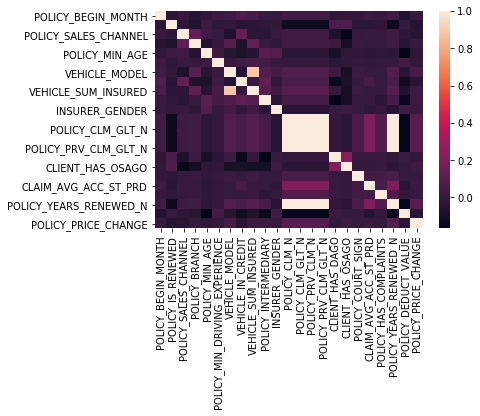

In [54]:
# Без преобразований для признаков производителей ТС и региона регистрации клиента
sns.heatmap(data.drop(['VEHICLE_MAKE', 'CLIENT_REGISTRATION_REGION'], axis=1).corr())

В данной интерпретации видны прямые зависимости между несколькими признаками. Посмотрим, какие пары признаков показывают высокую корреляцию (не будем рассматривать отдельно пары признаков **VEHICLE_MODEL** и **VEHICLE_SUM_INSURED**, так как мы намерено использовали преобразования из последнего для кодирования значений моеделей автомобилей).

['POLICY_CLM_GLT_N' 'POLICY_CLM_N' 'POLICY_PRV_CLM_GLT_N'
 'POLICY_PRV_CLM_N' 'POLICY_YEARS_RENEWED_N']


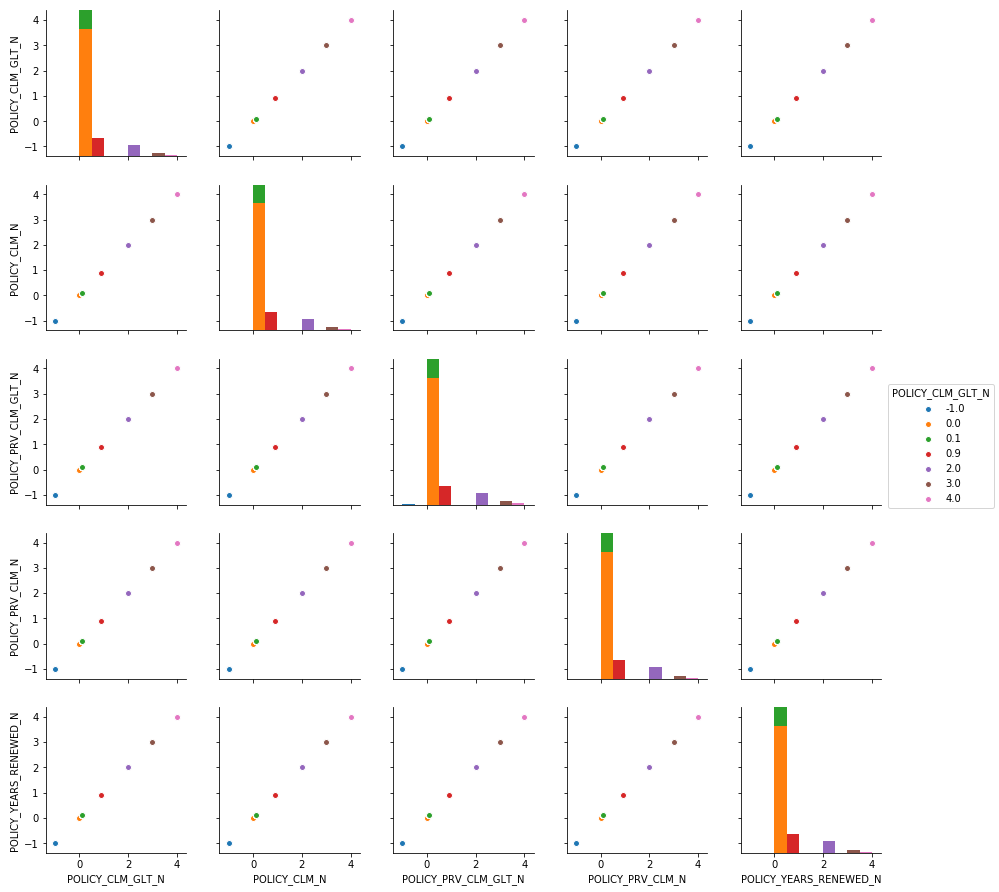

In [56]:
pairs_corr = []
data_corr = data.drop(['VEHICLE_MAKE', 'CLIENT_REGISTRATION_REGION'], axis=1).corr()
for i,k in data_corr.items():
    for j,v in k.items():
        if v > 0.9 and i != j:
            pairs_corr.append([i, j])
    
pairs_corr = np.unique(np.array(pairs_corr))
sns.pairplot(data[pairs_corr], hue=pairs_corr[0])
print(pairs_corr)

Очевидна линейная зависимость признаков **POLICY_CLM_GLT_N**, **POLICY_CLM_N**, **POLICY_PRV_CLM_GLT_N**, **POLICY_PRV_CLM_N**, **POLICY_YEARS_RENEWED_N** (в данной интерпретации кодирования этих признаков, как категориальных!). Соответственно, можно оставить только один из них без значимой потери информации).

In [58]:
# Оставим признак POLICY_CLM_N
arr_to_remove = list(pairs_corr)
arr_to_remove.remove('POLICY_CLM_N')
data.drop(arr_to_remove, axis=1, inplace=True)

In [59]:
# Добавляем столбцы с onehot-кодировнием категориальных значений
data = pd.concat([data, VEHICLE_MAKE_dummies, CLIENT_REGISTRATION_REGION_dummies], axis=1)
data.drop(['VEHICLE_MAKE', 'CLIENT_REGISTRATION_REGION'], axis=1, inplace=True)

In [60]:
data.shape

(96605, 188)

##  Работа с моделями

In [64]:
# Конечные значения для тренировки модели и прогноза

X_data = data[data['DATA_TYPE'] == 'TEST '].drop(['DATA_TYPE', 'POLICY_IS_RENEWED'], axis=1)
X_train_data = data[data['DATA_TYPE'] == 'TRAIN'].drop(['DATA_TYPE', 'POLICY_IS_RENEWED'], axis=1)
y_train_data = data[data['DATA_TYPE'] == 'TRAIN']['POLICY_IS_RENEWED']

In [65]:
# Поделим значения на обучающую и тестовую выборки в известных данных.
# Выберем то же соотношение 80% на обучение и 20% на тест

data_train = data[data['DATA_TYPE'] == 'TRAIN'].drop('DATA_TYPE', axis=1)
offset = int(data_train.shape[0] * 0.8)

X_train = data_train[:offset].drop('POLICY_IS_RENEWED', axis=1)
y_train = data_train['POLICY_IS_RENEWED'][:offset]

X_test = data_train[offset:].drop('POLICY_IS_RENEWED', axis=1)
y_test = data_train['POLICY_IS_RENEWED'][offset:]

In [66]:
print(X_train.shape)
print(y_train.shape)

(61925, 186)
(61925,)


In [71]:
# Соотношение классов
y_train.value_counts()

1    38782
0    23143
Name: POLICY_IS_RENEWED, dtype: int64

После проведенных тестов, наиболее эффективно показала себя модель градиентного бустинга. Опущу тестовые данные для модели (подбор оптимальных параметров по сетке, оценка качества на кросс-валидации и пр.) и не буду приводить сравнения моделей, покажу лишь качество итоговой.

In [67]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting = GradientBoostingClassifier(verbose=1, loss='exponential', max_depth=5, 
                                               min_samples_split=10, min_samples_leaf=8,
                                               n_estimators=500, random_state=10)

gradient_boosting.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.9587            9.66m
         2           0.9509            9.63m
         3           0.9440            9.64m
         4           0.9383            9.56m
         5           0.9322            9.63m
         6           0.9273            9.62m
         7           0.9235            9.70m
         8           0.9192            9.78m
         9           0.9159            9.71m
        10           0.9132            9.77m
        20           0.8938            9.95m
        30           0.8827            9.89m
        40           0.8752            9.64m
        50           0.8699            9.21m
        60           0.8652            8.78m
        70           0.8620            8.35m
        80           0.8587            7.95m
        90           0.8562            7.56m
       100           0.8540            7.17m
       200           0.8329            4.70m
       300           0.8161            2.99m
       40

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=8, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=10, subsample=1.0, verbose=1,
              warm_start=False)

testing score: 0.706433277354347 

             precision    recall  f1-score   support

          0       0.68      0.43      0.53      5888
          1       0.71      0.88      0.79      9594

avg / total       0.70      0.71      0.69     15482



C:\Users\lugA9\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


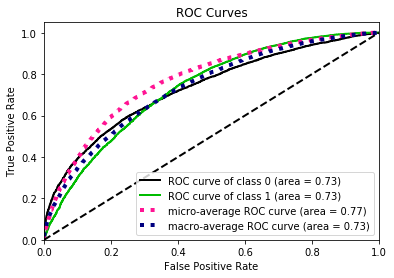

In [73]:
# Посмотрим на метрики качества получившейся классификации

from sklearn import metrics
import scikitplot as skplt

score = gradient_boosting.score(X_test, y_test)
predictions = gradient_boosting.predict(X_test)

print('testing score:', score, '\n')
print(metrics.classification_report(y_test, predictions))

y_true = y_test
y_probas = gradient_boosting.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

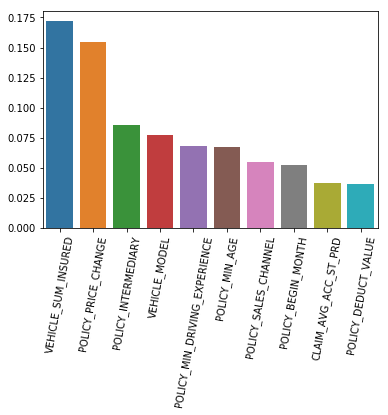

In [78]:
# Построим график топ-10 признаков, сыгравших основную роль в построении модели

df = pd.DataFrame({'importance': gradient_boosting.feature_importances_}, index=X_train.columns)
df = df.sort_values(by='importance', ascending=0)[:10]
sns.barplot(df['importance'].index, df['importance'].values)
plt.xticks(rotation=80)

In [26]:
# Обучим полуенную модель на полных данных, чтобы сделать окончательный прогноз

gradient_boosting.fit(X_train_data, y_train_data)

      Iter       Train Loss   Remaining Time 
         1           0.9593            6.21m
         2           0.9514            6.21m
         3           0.9447            6.22m
         4           0.9388            6.22m
         5           0.9326            6.23m
         6           0.9281            6.26m
         7           0.9243            6.28m
         8           0.9199            6.27m
         9           0.9167            6.26m
        10           0.9137            6.33m
        20           0.8948            6.42m
        30           0.8846            6.30m
        40           0.8768            6.32m
        50           0.8723            6.48m
        60           0.8683            6.21m
        70           0.8649            5.89m
        80           0.8622            5.59m
        90           0.8594            5.48m
       100           0.8567            5.23m
       200           0.8401            3.41m
       300           0.8262            2.09m
       40

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=8, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=10, subsample=1.0, verbose=1,
              warm_start=False)

In [39]:
predict = gradient_boosting.predict(X_data)
predict_proba = gradient_boosting.predict_proba(X_data)

In [60]:
answer = []
for i, j in enumerate(predict):
    answer.append([j, predict_proba[i, j]])

df_answer = pd.DataFrame(answer, index=X_data.index)
answer = pd.DataFrame.to_csv(df_answer, sep=';', header=None)

with open("predictions.txt", "w") as fout:
    fout.write(answer)